# Part 3: Regression for joint angles

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter
from scipy.signal import sosfiltfilt
from scipy.signal import welch

# Part 3.1: Visualizing and preprocessing the data

## Downloading the dataset and checking the data structure.

In [2]:
# load EMG data
data = loadmat("data/part_3/S1_E1_A1.mat")

### Dataset variables

In [3]:
print("Dataset variables:")
for key in data.keys():
    if not key.startswith("__"):
        print(key)

Dataset variables:
subject
exercise
emg
acc
gyro
mag
glove
stimulus
repetition
restimulus
rerepetition


### Dataset shape

In [4]:
#Performing a copy of the data
emg_data = data["emg"].copy()
#Stimulus is the type of movement that is being performed
stimulus = data["restimulus"] 
#Repetition is the number of times the movement has been repeated
repetition = data["rerepetition"] 
#glove is the calibrated signal from the sensors of the cyberglove
glove = data ["glove"]

print(f'Shape of Data \n    EMG: {emg_data.shape}\n    Stimulus {stimulus.shape}\n   Repetition {repetition.shape}\n Glove {glove.shape}')

# -1 because 0 is the resting condition
n_stimuli = len(np.unique(stimulus)) - 1 
# -1 because 0 is not a repetition
n_repetitions = len(np.unique(repetition)) - 1 
n_channels = emg_data.shape[1]

print('***')
print(f'Number of \n    Movements: {n_stimuli}\n    Repetitions: {n_repetitions}')

Shape of Data 
    EMG: (2292526, 16)
    Stimulus (2292526, 1)
   Repetition (2292526, 1)
 Glove (2292526, 18)
***
Number of 
    Movements: 9
    Repetitions: 10


### Extracting only relevant joints (3,6,8,11,14)

 Joint angles are involved in all movements so we consider all the EMG data

In [5]:
joint_angles = glove[:,[3,6,8,11,14]]

print("Joint angles data dimension: {}".format(joint_angles.shape))
print("Joint angles data type: {}".format(type(joint_angles)))

Joint angles data dimension: (2292526, 5)
Joint angles data type: <class 'numpy.ndarray'>


## EMG Pre-processing

In [6]:
fs = 2000 #fs found in data description
data_shape = emg_data.shape
number_timepoints = emg_data.shape[0]
number_channels = emg_data.shape[1]

print(f'The shape of the data is {data_shape}')
print(f'There are {number_timepoints} timepoints')
print(f'There are {number_channels} channels')

The shape of the data is (2292526, 16)
There are 2292526 timepoints
There are 16 channels


### Visualizing the EMG signals (I'm assuming here that it's in Volt not microvolt)

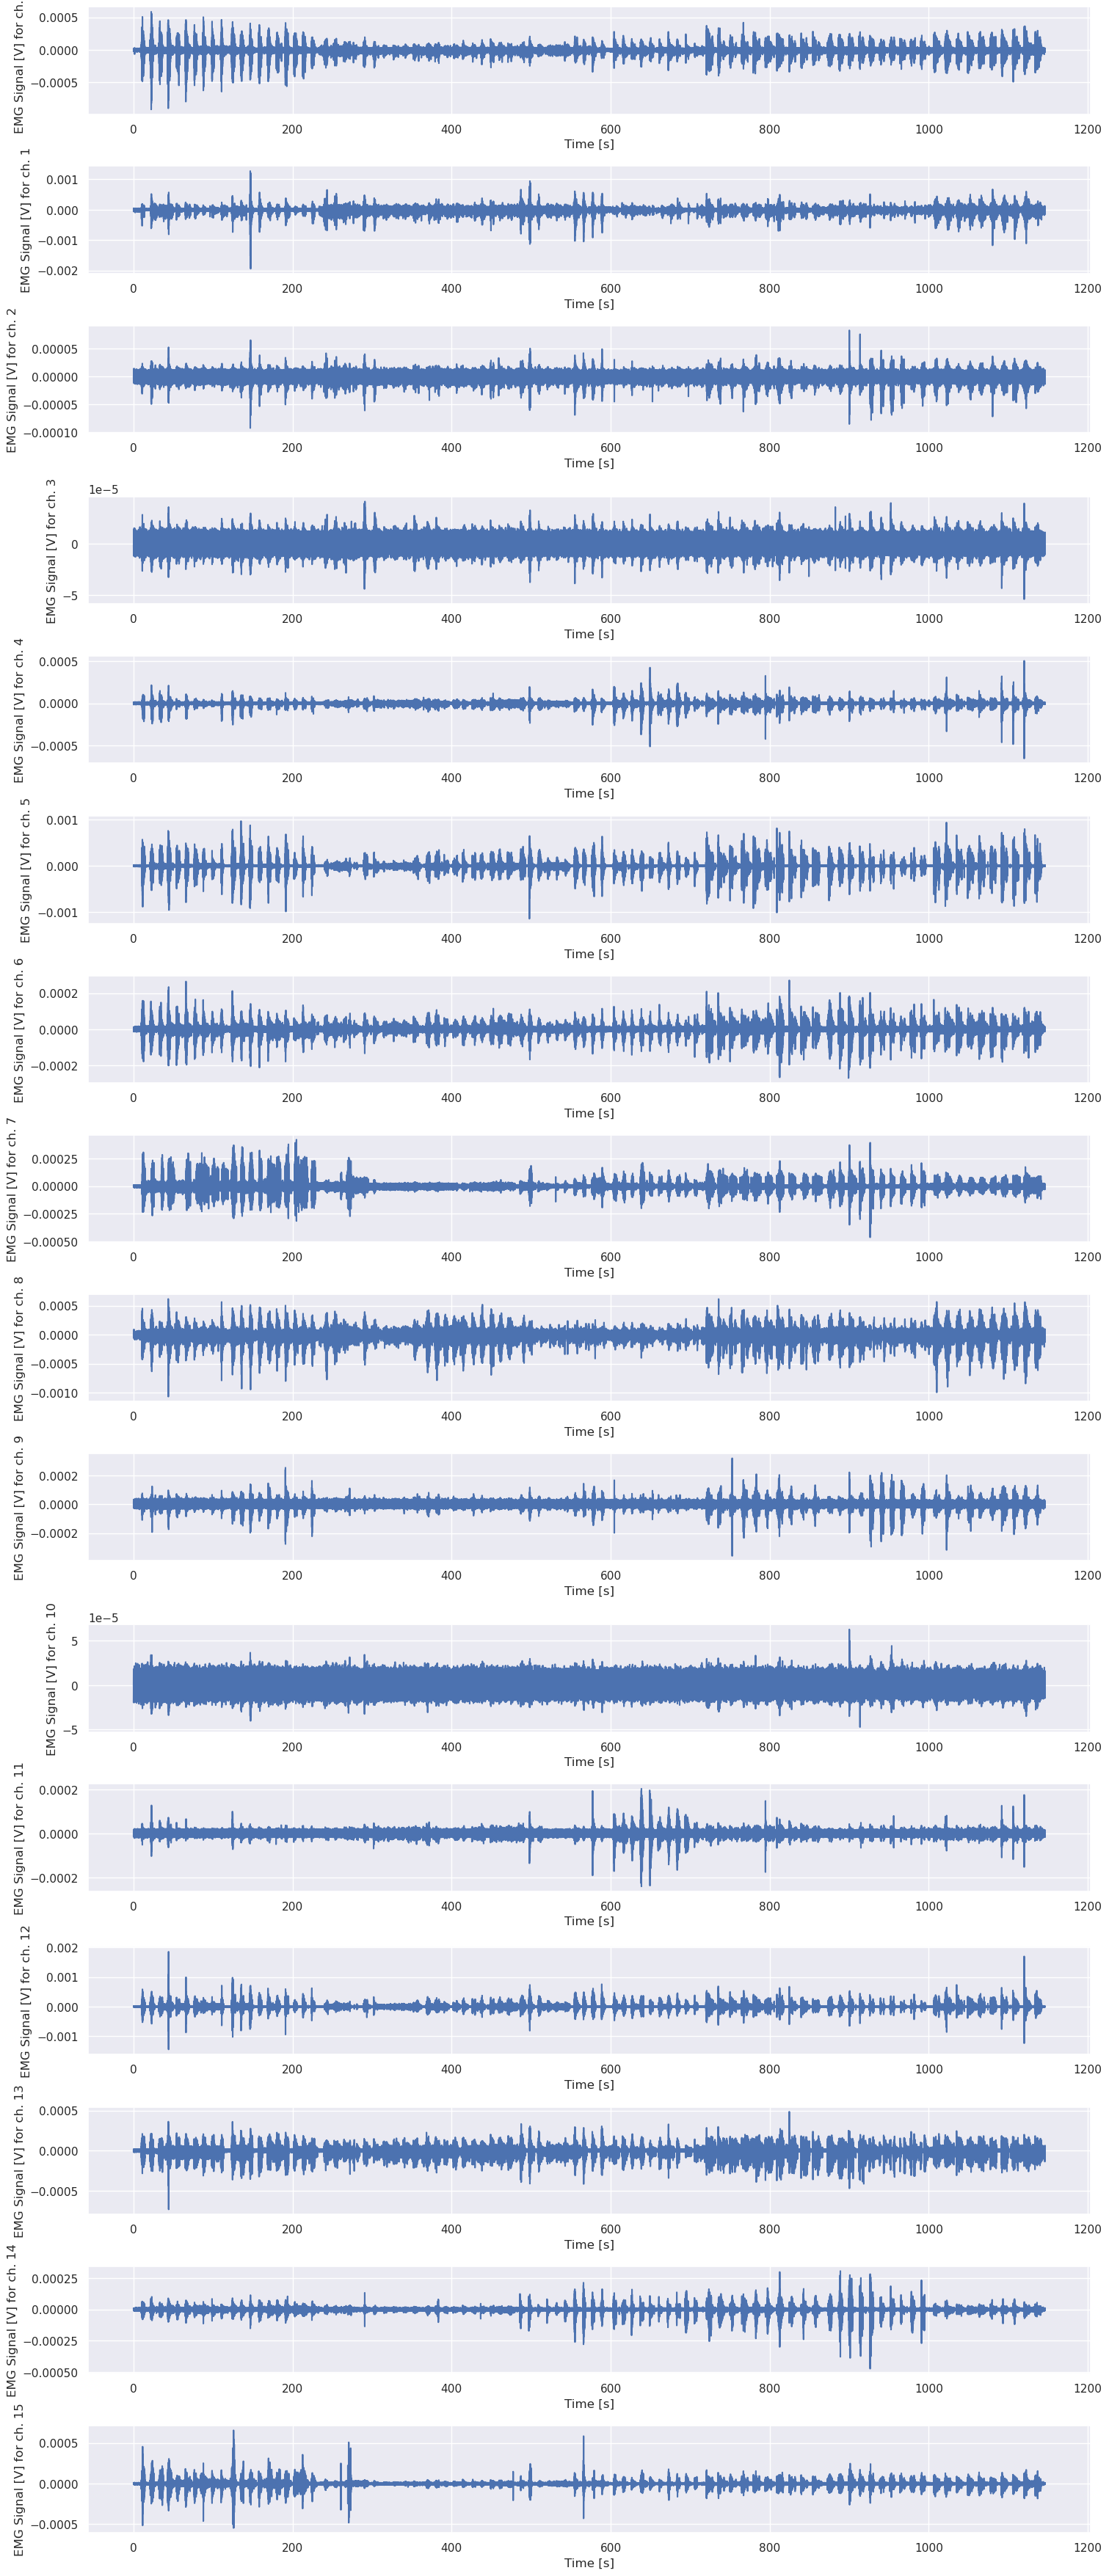

In [9]:
n_channels = emg_data.shape[1]

time_steps = np.arange(0,emg_data.shape[0]/fs, 1/fs) #Time vector for plotting

fig, ax = plt.subplots(n_channels, 1, constrained_layout=True, figsize=(15, 35),  gridspec_kw={'hspace': 0.1})
for channel_idx in range(n_channels):
    ax[channel_idx].plot(time_steps, emg_data[:, channel_idx])
    ax[channel_idx].set_xlabel("Time [s]")
    ax[channel_idx].set_ylabel(f'EMG Signal [V] for ch. {channel_idx}')


The plots show significant noise, we will use the welsh method to confirm if further filtering is indeed needed

Text(0.5, 1.0, 'Power Spectral Density plot in Log scale')

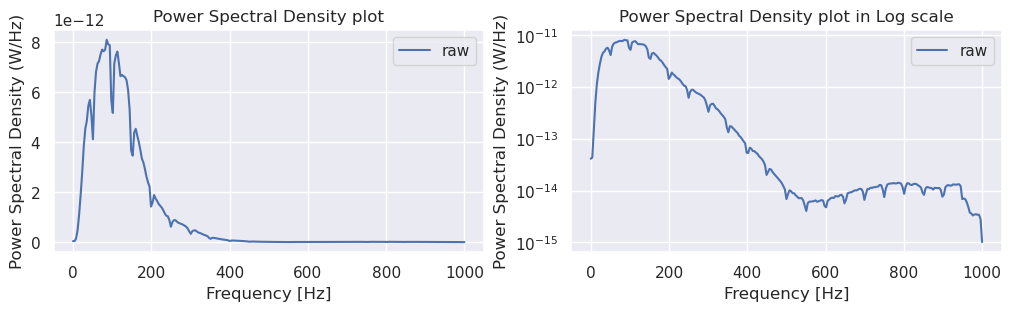

In [10]:
#Use Welch's method for power spectral density estimation, it reduces the variance of the estimate.
freqs_pre, Pxx_pre = welch(emg_data[:, 0], fs=fs, nperseg=512) 


fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 3))
ax[0].plot(freqs_pre, Pxx_pre, label="raw")
ax[0].legend()
ax[0].set_xlabel("Frequency [Hz]")
ax[0].set_ylabel("Power Spectral Density (W/Hz)")
ax[0].set_title("Power Spectral Density plot")

ax[1].semilogy(freqs_pre, Pxx_pre, label="raw")
ax[1].legend()
ax[1].set_xlabel("Frequency [Hz]")
ax[1].set_ylabel("Power Spectral Density (W/Hz)")
ax[1].set_title("Power Spectral Density plot in Log scale")

Indeed we confirm that further filtering is needed, especially since our data exhibits high frequency noise

### Filtering

### Pre-Processing verification: